# Decoding LEV-1's CW data

Tammo Jan Dijkema, 19 September 2024

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.dates import ConciseDateFormatter, num2date
import re
import numpy as np
from datetime import datetime, timedelta

The screenshot in [this tweet](https://x.com/radio_no_koe/status/1827546985748119763) shows the decoding of one of the CW packets of LEV-1. Using the numbers in the right-most column, we can count the number of bits used for each telemetry item.

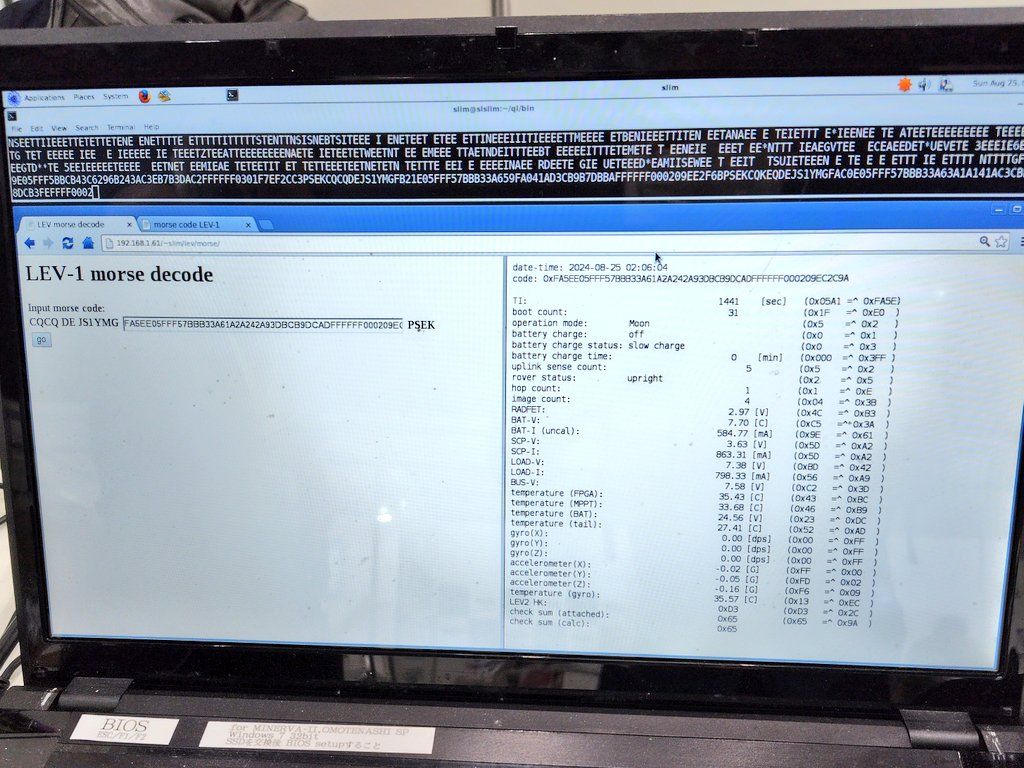

For reference, this is the text in the screenshot:
```
code: 0xFA5E E05F FF57 BBB3 3A61 A2A2 42A9 3DBC B9DC ADFF FFFF 0002 09EC 2C9A

TI:                                     1441    [sec]   (0x05A1 =^ 0xFA5E)
boot count:                               31            (0x1F   =^ 0xE0  )
operation mode:        Moon                             (0x5    =^ 0x2   )
battery charge:        off                              (0x0    =^ 0x1   )
battery charge status: slow charge                      (0x0    =^ 0x3   )
battery charge time:                       0    [min]   (0x000  =^ 0x3FF )
uplink sense count:                           5         (0x5    =^ 0x2   )
rover status:          upright                          (0x2    =^ 0x5   )
hop count:                                    1         (0x1    =^ 0xE   )
image count:                                  4         (0x04   =^ 0x3B  )
RADFET:                                    2.97 [V]     (0x4C   =^ 0xB3  )
BAT-V:                                     7.70 [C]     (0xC5   =^ 0x3A  )
BAT-I (uncal):                           584.77 [mA]    (0x9E   =^ 0x61  )
SCP-V:                                     3.63 [V]     (0x5D   =^ 0xA2  )
SCP-I:                                   863.31 [mA]    (0x5D   =^ 0xA2  )
LOAD-V:                                    7.38 [V]     (0xBD   =^ 0x42  )
LOAD-I:                                  798.33 [mA]    (0x56   =^ 0xA9  )
BUS-V:                                     7.58 [V]     (0xC2   =^ 0x3D  )
temperature (FPGA):                       35.43 [C]     (0x43   =^ 0xBC  )
temperature (MPPT):                       33.68 [C]     (0x46   =^ 0xB9  )
temperature (BAT):                        24.56 [V]     (0x23   =^ 0xDC  )
temperature (tail):                       27.41 [C]     (0x52   =^ 0xAD  )
gyro(X):                                   0.00 [dps]   (0x00   =^ 0xFF  )
gyro(Y):                                   0.00 [dps]   (0x00   =^ 0xFF  )
gyro(Z):                                   0.00 [dps]   (0x00   =^ 0xFF  )
accelerometer(X):                         -0.02 [G]     (0xFF   =^ 0x00  )
accelerometer(Y):                         -0.05 [G]     (0xFD   =^ 0x02  )
accelerometer(Z):                         -0.16 [G]     (0xF6   =^ 0x09  )
temperature (gyro):                       35.57 [C]     (0x13   =^ 0xEC  )
LEV2 HK:                                   0xD3         (0xD3   =^ 0x2C  )
check sum (attached):                      0x65         (0x65   =^ 0x9A  )
check sum (calc):                          0x65
```

The number of bits for the fields can be found by matching the last column of the screenshot with the binary value of the code. The number of bits per field are:

In [ ]:
num_bits = (16, 8, 3, 1, 2, 10, 3, 3, 4, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8)

This reproduces the hex codes in the rightmost column:

In [ ]:
code = 0xFA5EE05FFF57BBB33A61A2A242A93DBCB9DCADFFFFFF000209EC2C9A
input_bits = bin(code)[2:]  # Strip 0b
current_bit = 0
for field_num, b in enumerate(num_bits):
    bit_part = input_bits[current_bit: current_bit + b]
    print(hex(int(bit_part, 2)).upper())
    current_bit += b

0XFA5E
0XE0
0X2
0X1
0X3
0X3FF
0X2
0X5
0XE
0X3B
0XB3
0X3A
0X61
0XA2
0XA2
0X42
0XA9
0X3D
0XBC
0XB9
0XDC
0XAD
0XFF
0XFF
0XFF
0X0
0X2
0X9
0XEC
0X2C
0X9A


The total number of bits (224) corresponds to the length of the telemetry in the CW, which consists of 28 bytes.

In [ ]:
field_names = [
    "TI",
    "boot count",
    "operation mode",
    "battery charge",
    "battery charge status",
    "battery charge time",
    "uplink sense count",
    "rover status",
    "hop count",
    "image count",
    "RADFET",
    "BAT-V",
    "BAT-I (uncal)",
    "SCP-V",
    "SCP-I",
    "LOAD-V",
    "LOAD-I",
    "BUS-V",
    "temperature (FPGA)",
    "temperature (MPPT)",
    "temperature (BAT)",
    "temperature (tail)",
    "gyro(X)",
    "gyro(Y)",
    "gyro(Z)",
    "accelerometer(X)",
    "accelerometer(Y)",
    "accelerometer(Z)",
    "temperature (gyro)",
    "LEV2 HK",
    "check sum (attached)",
]

To get the value of a field, we need to take the two's complement of the corresponding bits. The following function takes a hexadecimal string and decodes it.

In [ ]:
def decode_cw(input_str):
    """Decode LEV-1 CW telemetry"""
    input_str = input_str.replace(" ", "")

    # Hack: remove everything after first * or ?
    input_str = re.split(r'[*?]', input_str, 1)[0]

    input_bits = bin(int(input_str, 16))[2:]  # remove 0b

    result = {}

    current_bit = 0
    for field_num, b in enumerate(num_bits):
        field_name = field_names[field_num]
        if current_bit + b > len(input_bits):
            print("Truncated message")
            break
        try:
            field_complement = int(input_bits[current_bit: current_bit + b], 2)
            fs = int("1" * b, 2)
            field = fs - field_complement
            result[field_name] = field
        except ValueError:
            pass
        current_bit += b

    return result

These are the strings manually decoded from the CW received with the Dwingeloo telescope:

In [ ]:
decoded_strings = """\
15:28:20                  FE2E E05F FF3B FFB6 3860 8DDC 3FBB 3BA1 9AD3 AFFF FFFF FE02 A6FD 378F PSE K
15:35:21  CQ CQ DE JS1YMG FC8C E05F FFCD B43A *
15:40:03  CQ CQ DE JS1YMG FB79 E05F FF5B BCB4 3C62 96B2 43AC 3EB7 B3DA C2FF FFFF 0301 F7EF 2CC3 PSE K
15:41:43  CQ CQ DE JS1YMG FB21 E05F FF57 BBB3 3A65 9FA0 41AD 3CB9 B7DB BAFF FFFF 0002 09EE 2F6B PSE K
15:43:21  CQ CQ DE JS1YMG FAC0 E05F FF57 BBB3 3A63 A1A1 41AC 3CBB B8DC B3FE FFFF 0002 09ED 2F04 PSE K
15:45:00  CQ CQ DE JS1YMG FA5E E05F FF57 BBB3 3A61 A2A2 42A9 3DBC B9DC ADFF FFFF 0002 09EC 2C9A PSE K
15:46:37  CQ CQ DE JS1YMG F9FF E05F FF57 BBB3 3B5F A2A2 42A3 3DBD BADD A8FF FFFF 0003 0AEB 2F35 PSE K
15:48:12  CQ CQ DE JS1YMG F9A1 E05F FF57 BBB3 3B60 A2A
15:50:59     CQ DE JS1YMG F8F4 E05F FF4F BAB3 3B63 A2A2 42B0 3
16:21:53  CQ CQ DE JS1YMG F1D7 E05F FFAF 34?? 404A ?
16:29:21  CQ CQ DE JS1YMG F027 E05F FF76 F2B0 404B D5FC 4AA2 44DA D7EF DCFC FFFF 0200 09C9 2C8C PSE K
16:31:02  CQ CQ DE JS1YMG EFC4 E05F FF76 F2AF 404A D5FC 4B9F 45DA D8F0 DEFF FFFF 0300 0AC8 2C2A PSE K
16:32:39  CQ CQ DE JS1YMG EF64 E05F FF76 F2AF 4*
16:36:40           JS1YMG EE75 E05F FF4A ??AF 3551 D5FC 49AE 43D
16:41:26              YMG ED64 E05F FF3A B0AF 3D62 99BA 44B2 3FDE DDF3 E3FF FFFF FD02 F6C0 2CD8 PSE K
16:42:48  CQ CQ DE JS1YMG ED0F E05F FF36 AFAE 3D60 A1B2 44AA 3FDE DEF3 DFFF FFFF 0100 0ABF 2C85 PSE K
16:44:22  CQ CQ DE JS1YMG ECB3 E05F FF36 AFAE 3D5E A2B6 45A9 40DF BEF3 BBFF FFFF 0001 0ABF 2C29 PSE K
16:45:56  CQ CQ DE JS1YMG EC56 E05F FF36 AFAE 3B5A A2B9 46A3 41DF DEF3 D9FF FFFF 0103 0ABE 1FF5 PSE K
16:47:30  CQ CQ DE JS1YMG EBFB E05F FF36 AFAE 3E58 A2BB 47A0 44DF DEF3 D7FF FFFF 0201 0ABE 2C67 PSE K
16:49:02  CQ CQ DE JS1YMG EB9F E05F FF36 AFAE 3E58 A2BA 679F 41BF DEF3 D*
16:52:28  CQ CQ DE JS1YMG EAC6 E05F FF0E AEAE 3E5E BA2C ???? 91*
16:57:10     CQ DE JS1YMG E9BB E05F FFFA 6DAE 3E65 9FA9 65B2 40E0 DFF4 DEFF FFFF FD03 F7BA 2C9E PSE K
16:58:39  CQ CQ DE JS1YMG E96A E05F FFF6 6CAE 3E61 A1AC 45AE 40E? ???? ???? ???? ???? ?ABA 2C58 PSE K
17:00:12  CQ CQ DE JS1YMG E90E E05F FFF6 6CAE 3E60 A1?? ?5AB 40E0 E0F5 B7FF FFFF ???? 0ABA 2CF9 PSE K
17:01:47  CQ CQ DE JS1YMG E8B9 E05F FFF6 6CAE 3E5F A1B0 49A9 45E0 E0F5 D5FF FFFF 0202 0AB9 2C98 PSE K
17:03:25  CQ CQ DE JS1YMG E850 E05F FFF6 6CAE 3E5F A1AF 49AB 40E0 E0F5 D4FF FFFF 0103 09B9 2C36 PSE K
17:05:02  CQ CQ DE JS1YMG E7F1 E05F FFF6 6CAE 3F5B A1AE 47A0 41E0 E0F*
17:06:49      Q DE JS1YMG E784 E05F FFCE 6BAE 3E?? A1AE 3ED? 40E0 E0F5 D3FF FFFF 0
""".splitlines()

# Decode all transcribed Dwingeloo CW

In [ ]:
messages = {}

for line in decoded_strings:
    time_str = line[:8]
    messages[time_str] = line[26:-6]

In [ ]:
results = {}
for msg_time, message in messages.items():
    results[msg_time] = decode_cw(message)

Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message
Truncated message


Number of decoded fields per message:

In [ ]:
[(key, len(val)) for key, val in results.items()]

[('15:28:20', 31),
 ('15:35:21', 8),
 ('15:40:03', 31),
 ('15:41:43', 31),
 ('15:43:21', 31),
 ('15:45:00', 31),
 ('15:46:37', 31),
 ('15:48:12', 12),
 ('15:50:59', 15),
 ('16:21:53', 10),
 ('16:29:21', 31),
 ('16:31:02', 31),
 ('16:32:39', 9),
 ('16:36:40', 8),
 ('16:41:26', 31),
 ('16:42:48', 31),
 ('16:44:22', 31),
 ('16:45:56', 31),
 ('16:47:30', 31),
 ('16:49:02', 19),
 ('16:52:28', 15),
 ('16:57:10', 31),
 ('16:58:39', 18),
 ('17:00:12', 14),
 ('17:01:47', 31),
 ('17:03:25', 31),
 ('17:05:02', 18),
 ('17:06:49', 12)]

These are the values corresponding to the screenshot of the tweet:

In [ ]:
for key, val in results["15:45:00"].items():
    print(f"{key:22s}: {val}")

TI                    : 1441
boot count            : 31
operation mode        : 5
battery charge        : 0
battery charge status : 0
battery charge time   : 0
uplink sense count    : 5
rover status          : 2
hop count             : 1
image count           : 4
RADFET                : 76
BAT-V                 : 197
BAT-I (uncal)         : 158
SCP-V                 : 93
SCP-I                 : 93
LOAD-V                : 189
LOAD-I                : 86
BUS-V                 : 194
temperature (FPGA)    : 67
temperature (MPPT)    : 70
temperature (BAT)     : 35
temperature (tail)    : 82
gyro(X)               : 0
gyro(Y)               : 0
gyro(Z)               : 0
accelerometer(X)      : 255
accelerometer(Y)      : 253
accelerometer(Z)      : 246
temperature (gyro)    : 19
LEV2 HK               : 211
check sum (attached)  : 101


In [ ]:
def read_field(field_name):
    """Read all decoded values for the given field"""
    results_with_field = {key: value for key, value in results.items() if field_name in value}
    times = [result['TI'] for result in results_with_field.values()]
    values = [result[field_name] for result in results_with_field.values()]
    msg_times_str = list(results_with_field.keys())
    msg_times = [datetime.fromisoformat("2024-01-19 " + msg_time) for msg_time in msg_times_str]
    return msg_times, times, values

Plot all fields:

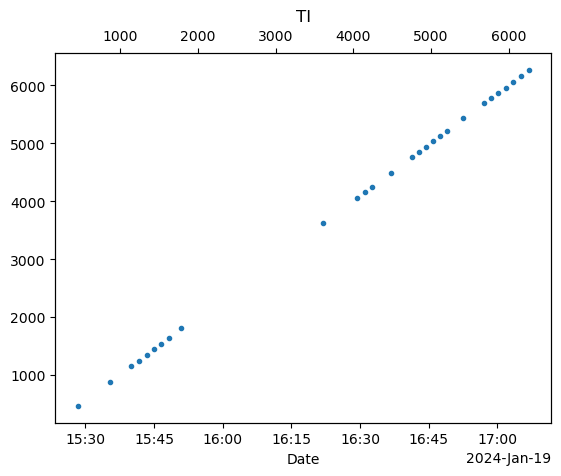

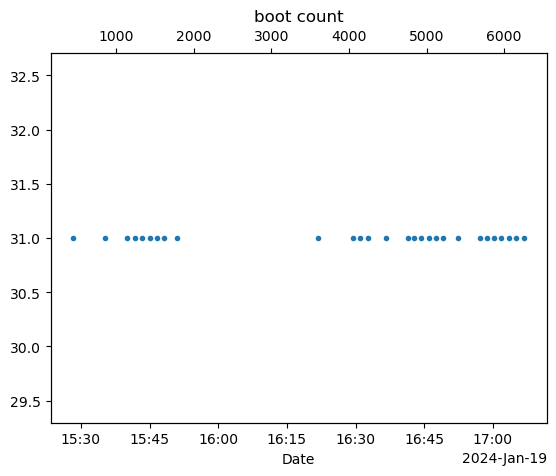

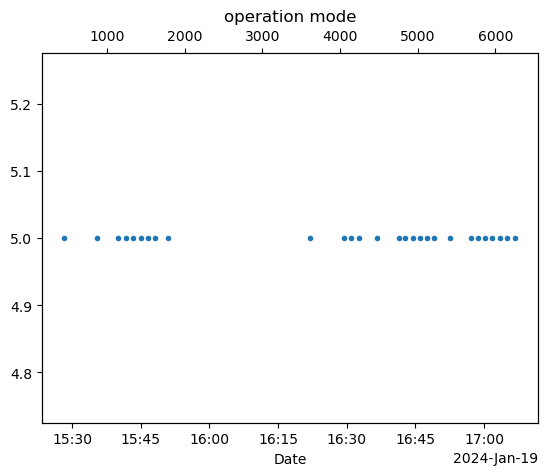

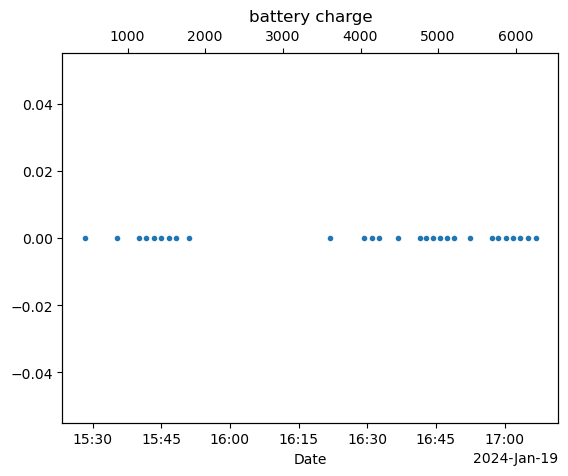

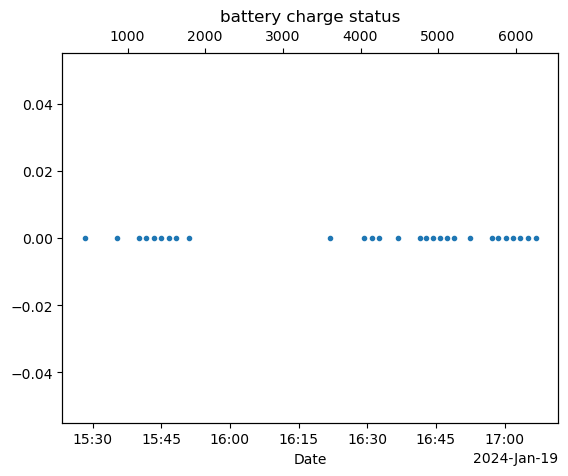

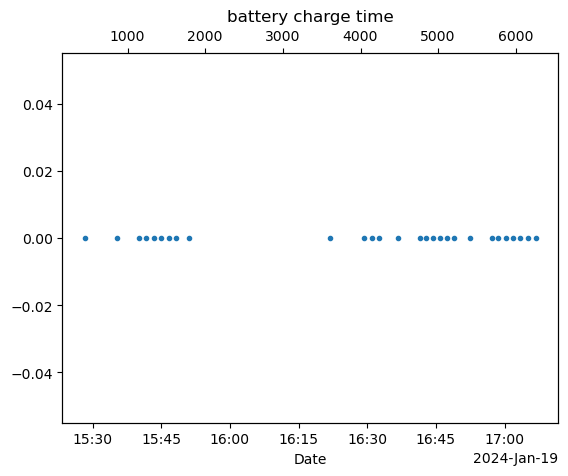

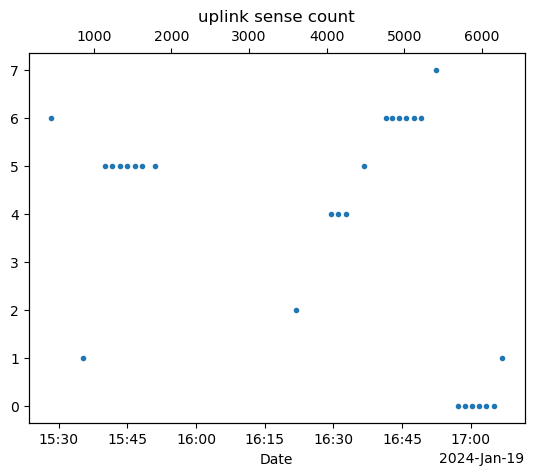

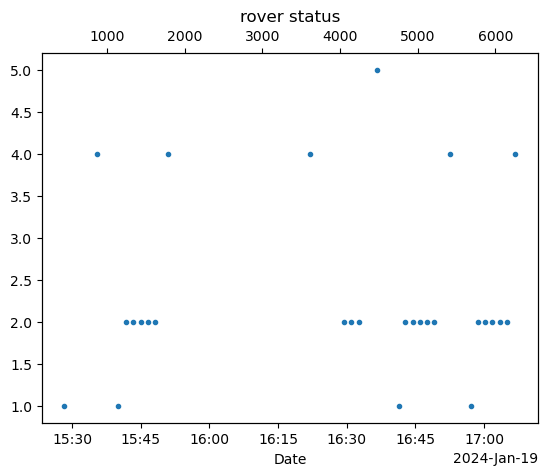

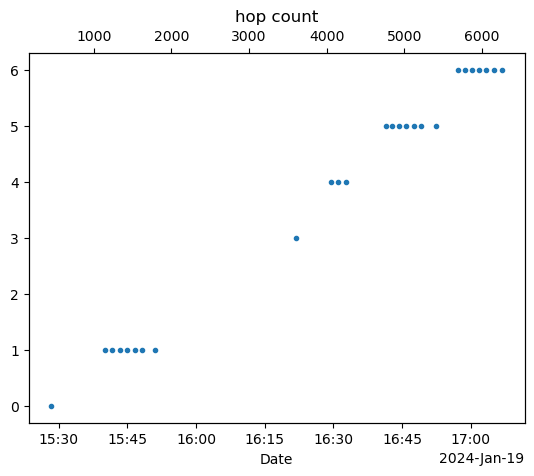

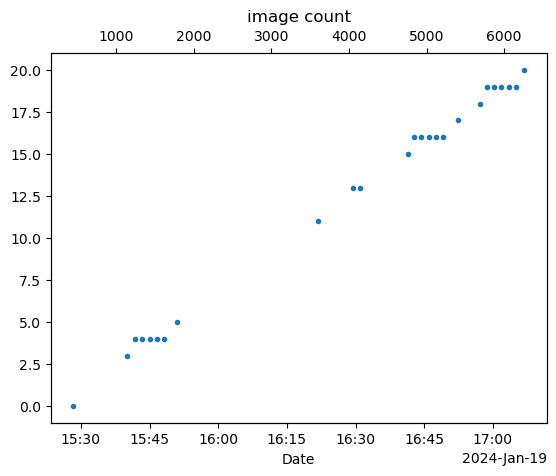

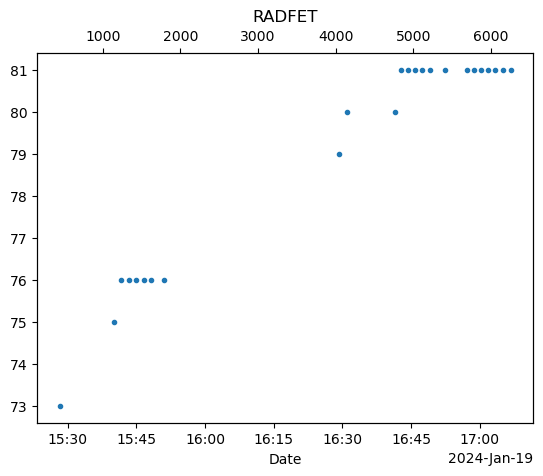

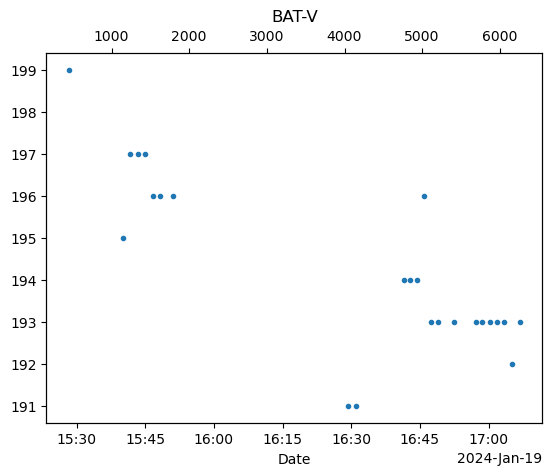

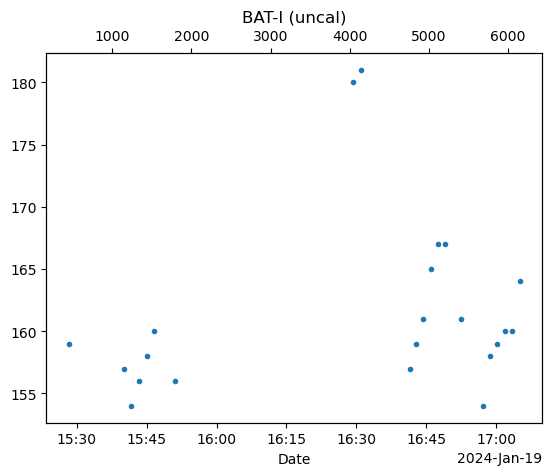

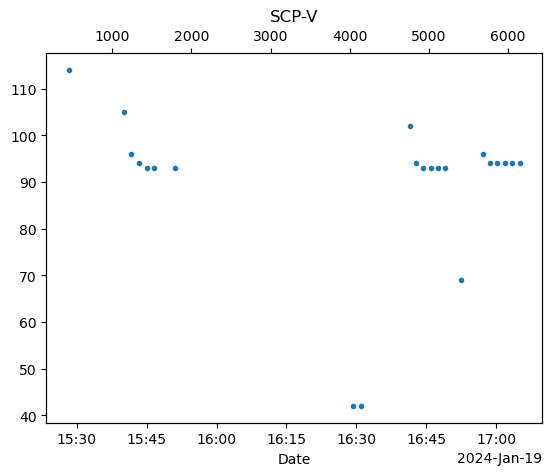

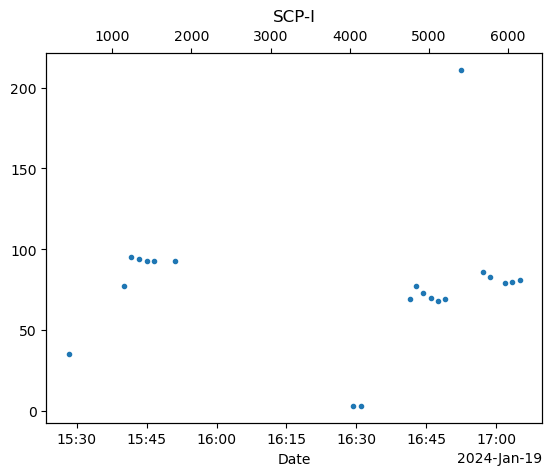

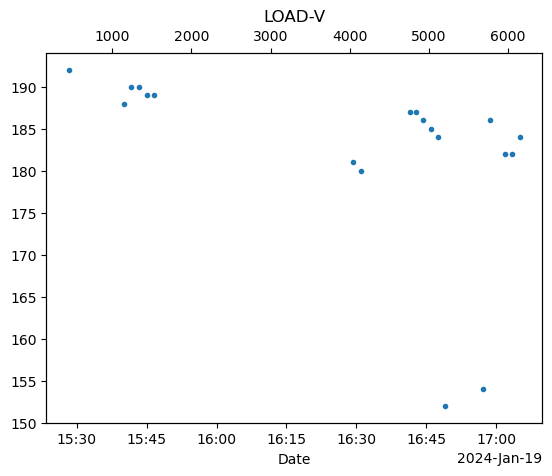

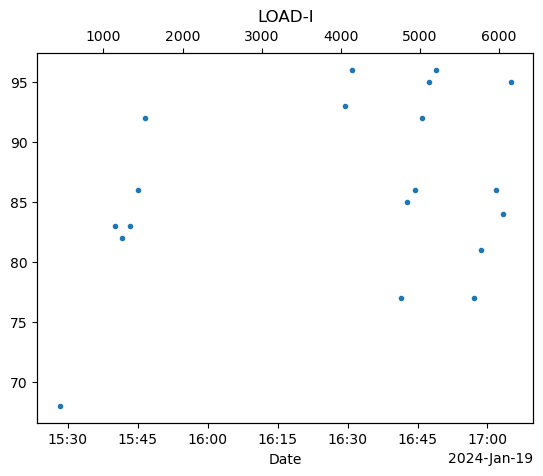

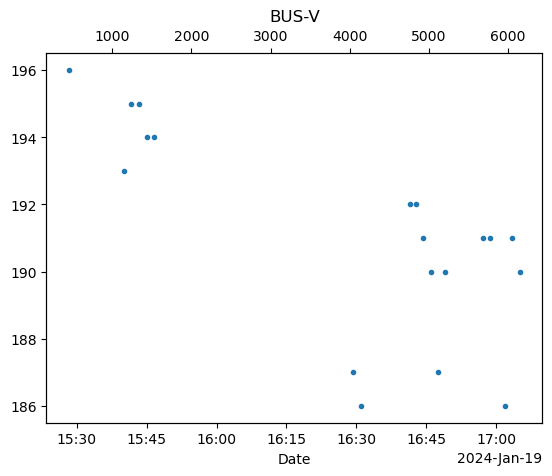

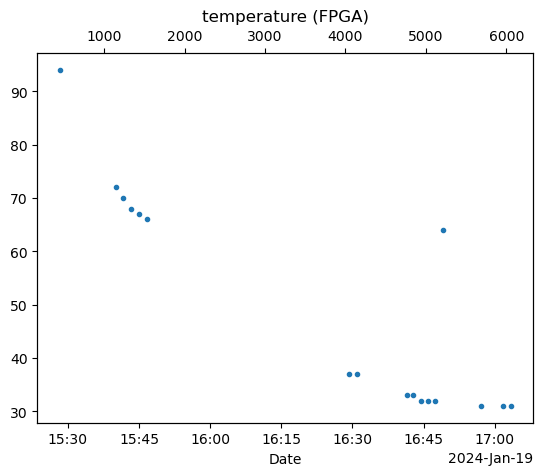

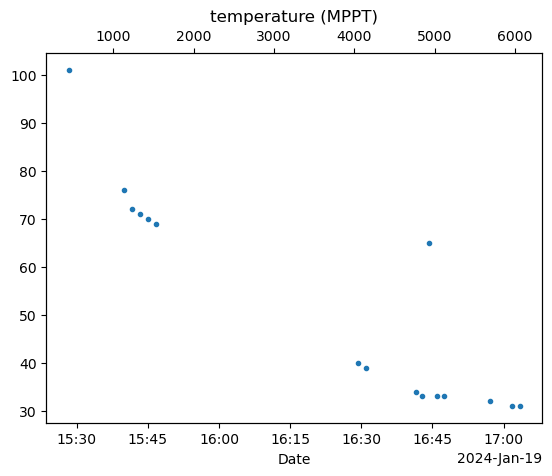

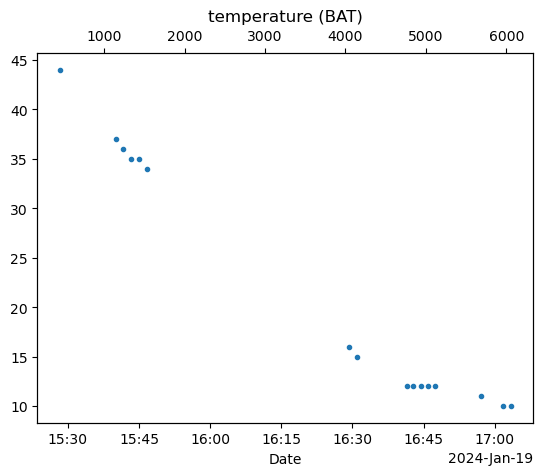

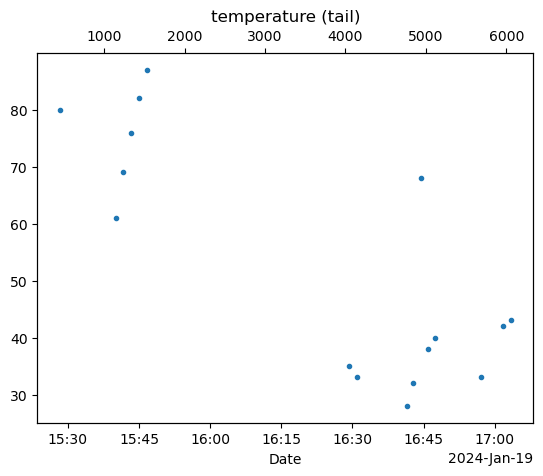

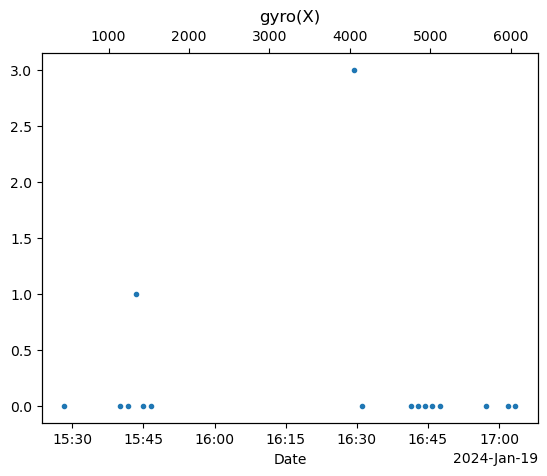

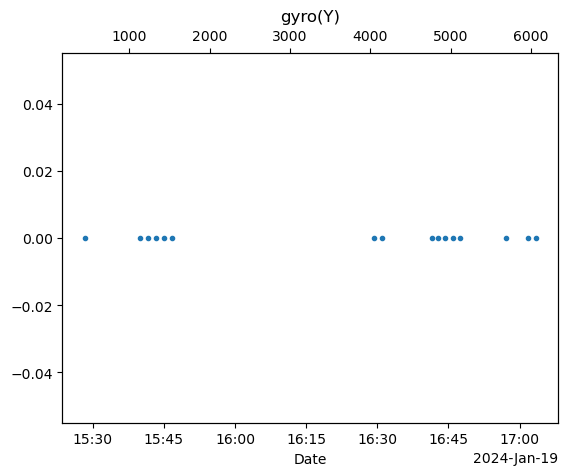

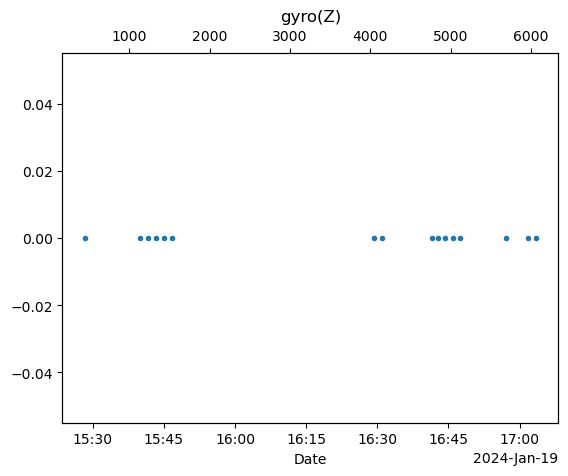

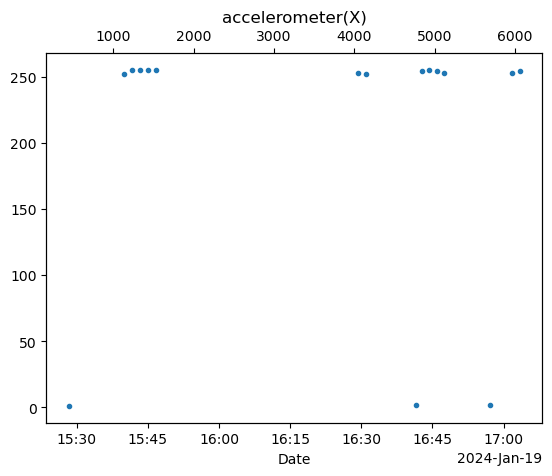

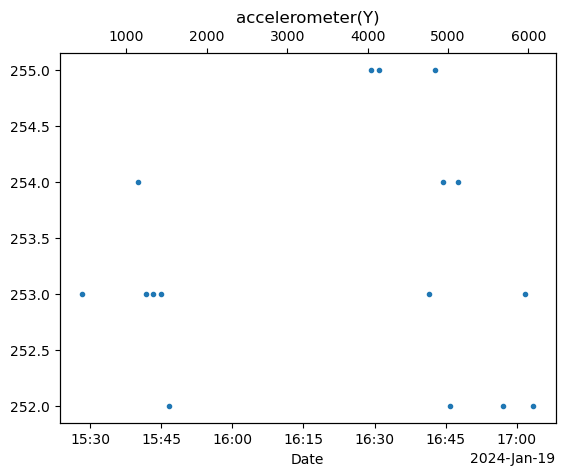

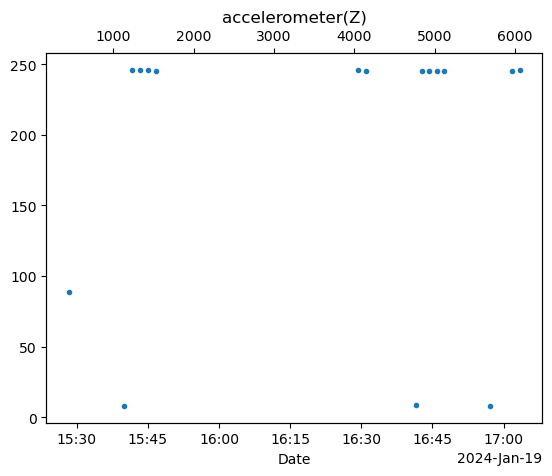

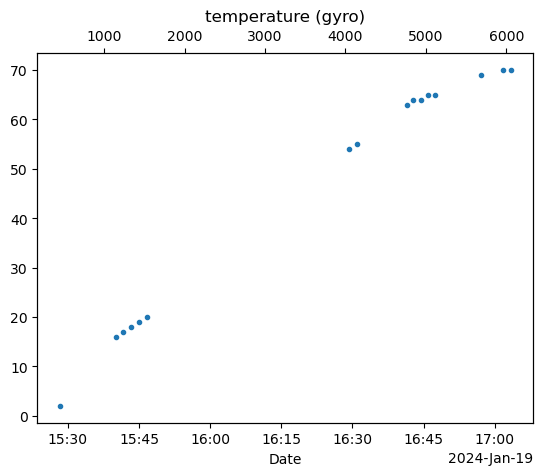

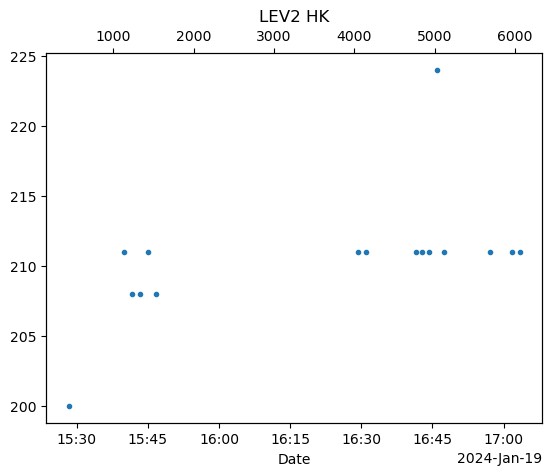

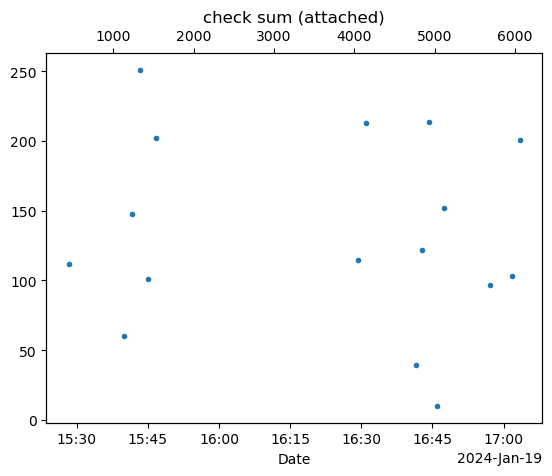

In [ ]:
%matplotlib inline
for field_name in field_names:
    msg_times, plot_times, plot_values = read_field(field_name)
    fig, ax = plt.subplots()
    ax.plot(msg_times, plot_values, ".")
    ax.set_title(field_name)
    ax.xaxis.set_major_formatter(ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.set_xlabel("Date");

    topax = ax.twiny()
    datetime_min, datetime_max = ax.get_xlim()
    ti_min = time_to_ti(num2date(datetime_min))
    ti_max = time_to_ti(num2date(datetime_max))
    topax.set_xlim(ti_min, ti_max)
    
    plt.show()
    plt.close(fig)

# Determine clock rate

In [ ]:
msg_times, _, ti_values = read_field("TI")

In [ ]:
elapsed_times = [(msg_time - msg_times[0]).total_seconds() for msg_time in msg_times]

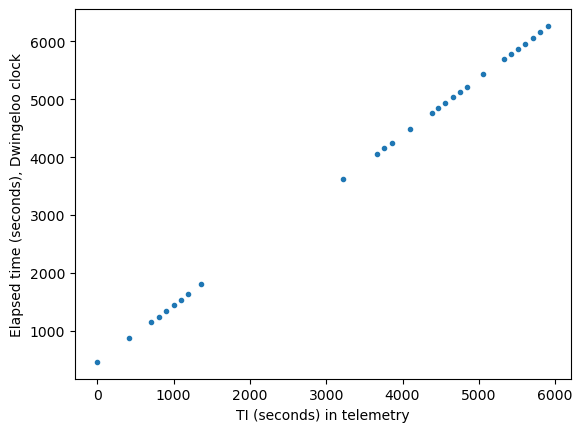

In [ ]:
fig, ax = plt.subplots()
ax.plot(elapsed_times, ti_values, ".")
ax.set_xlabel("TI (seconds) in telemetry")
ax.set_ylabel("Elapsed time (seconds), Dwingeloo clock");

In [ ]:
from numpy.polynomial import Polynomial

In [ ]:
x_values = np.array(elapsed_times)
y_values = np.array(ti_values) - np.array(elapsed_times)

In [ ]:
fit = Polynomial.fit(x_values[~np.isnan(y_values)], y_values[~np.isnan(y_values)], 1).convert()

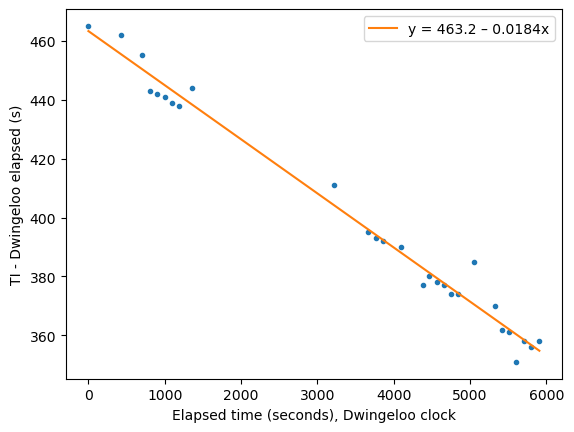

In [ ]:
fig, ax = plt.subplots()
ax.plot(elapsed_times, np.array(ti_values) - np.array(elapsed_times), ".");
ax.plot(elapsed_times, fit(np.array(elapsed_times)), label=f"y = {fit.coef[0]:.1f} – {-fit.coef[1]:.4f}x")
ax.plot(x_values[np.isnan(y_values)], (np.array(ti_values) - np.array(elapsed_times))[np.isnan(y_values)], 'r.')
ax.set_xlabel("Elapsed time (seconds), Dwingeloo clock");
ax.set_ylabel("TI - Dwingeloo elapsed (s)")
ax.legend();

In [ ]:
y_values[0] = np.nan
y_values[1] = np.nan
y_values[2] = np.nan
y_values[8] = np.nan
y_values[9] = np.nan
y_values[13] = np.nan
y_values[14] = np.nan
y_values[18] = np.nan
y_values[20] = np.nan
y_values[21] = np.nan
y_values[24] = np.nan
y_values[27] = np.nan

In [ ]:
fit = Polynomial.fit(x_values[~np.isnan(y_values)], y_values[~np.isnan(y_values)], 1).convert()

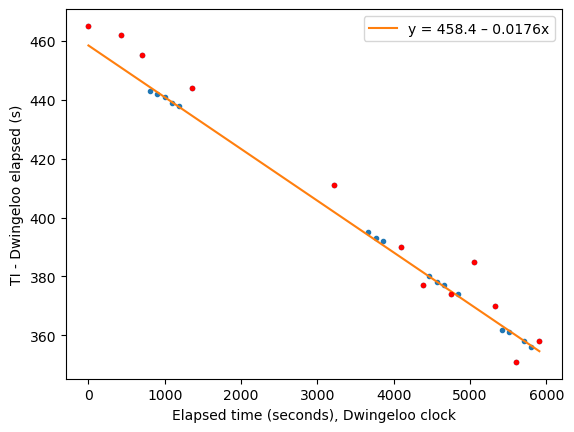

In [ ]:
fig, ax = plt.subplots()
ax.plot(elapsed_times, np.array(ti_values) - np.array(elapsed_times), ".");
ax.plot(elapsed_times, fit(np.array(elapsed_times)), label=f"y = {fit.coef[0]:.1f} – {-fit.coef[1]:.4f}x")
ax.plot(x_values[np.isnan(y_values)], (np.array(ti_values) - np.array(elapsed_times))[np.isnan(y_values)], 'r.')
ax.set_xlabel("Elapsed time (seconds), Dwingeloo clock");
ax.set_ylabel("TI - Dwingeloo elapsed (s)")
ax.legend();

It seems that the on board time is a bit slower than the Dwingeloo clock.

In [ ]:
fit

Polynomial([ 4.58368079e+02, -1.75554106e-02], domain=[-1.,  1.], window=[-1.,  1.])

In [ ]:
def fit_hardcoded(ti):
    return 458.37 - 0.01755 * ti

In [ ]:
def ti_to_time(ti):
    return datetime(2024, 1, 19, 15, 28, 20) + timedelta(seconds=ti - fit_hardcoded(ti))

In [ ]:
def time_to_ti(d):
    if isinstance(d, str):
        d = datetime.fromisoformat(d)

    elapsed = (d.replace(tzinfo=None) - datetime(2024, 1, 19, 15, 28, 20)).total_seconds()

    # Solve: ti = elapsed + fit_hardcoded(ti)
    ti = (elapsed + 458.38) / 1.01757
    
    return ti

# Hops

In [ ]:
hops_in_waveform = "2024-01-19 16:57:10", "2024-01-19 16:53:05", "2024-01-19 16:37:03", "2024-01-19 16:22:25", "2024-01-19 15:51:40", "2024-01-19 15:40:02", "2024-01-19 15:35:45"

In [ ]:
hops_datetime = [datetime.fromisoformat(d) for d in sorted(hops_in_waveform)]

In [ ]:
hops_datetime

[datetime.datetime(2024, 1, 19, 15, 35, 45),
 datetime.datetime(2024, 1, 19, 15, 40, 2),
 datetime.datetime(2024, 1, 19, 15, 51, 40),
 datetime.datetime(2024, 1, 19, 16, 22, 25),
 datetime.datetime(2024, 1, 19, 16, 37, 3),
 datetime.datetime(2024, 1, 19, 16, 53, 5),
 datetime.datetime(2024, 1, 19, 16, 57, 10)]

In [ ]:
for h in sorted(hops_in_waveform):
    print(h[-8:], f"{time_to_ti(h):.1f}")

15:35:45 887.8
15:40:02 1140.3
15:51:40 1826.3
16:22:25 3639.4
16:37:03 4502.3
16:53:05 5447.7
16:57:10 5688.4


In [ ]:
msg_times, times, plot_values = read_field("hop count")

In [ ]:
time_to_ti(hops_in_waveform[0])

5688.434210914236

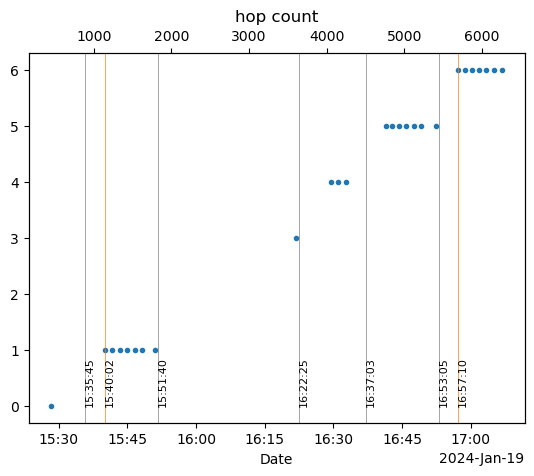

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(msg_times, plot_values, ".")
ax.set_title("hop count")
ax.xaxis.set_major_formatter(ConciseDateFormatter(ax.xaxis.get_major_locator()))

topax = ax.twiny()
datetime_min, datetime_max = ax.get_xlim()
ti_min = time_to_ti(num2date(datetime_min))
ti_max = time_to_ti(num2date(datetime_max))
topax.set_xlim(ti_min, ti_max)

for t in [sorted(hops_in_waveform)[i] for i in [0, 2, 3, 4, 5]]:
    ax.axvline(datetime.fromisoformat(t), linewidth=0.5, color='gray');
    ax.text(datetime.fromisoformat(t), 0.05, t[-8:], transform=ax.get_xaxis_transform(), rotation=90, fontsize=8)
for t in [sorted(hops_in_waveform)[i] for i in [1, 6]]:
    ax.axvline(datetime.fromisoformat(t), linewidth=0.5, color='C1');
    ax.text(datetime.fromisoformat(t), 0.05, t[-8:], transform=ax.get_xaxis_transform(), rotation=90, fontsize=8)
ax.set_xlabel("Date");

# Meaning of rover status

In [ ]:
bochum_plot = plt.imread("status_plot_bochum.jpg")

In [ ]:
msg_times, times, plot_values = read_field("rover status")

In [ ]:
msg_times[13]

datetime.datetime(2024, 1, 19, 16, 36, 40)

In [ ]:
times

[465,
 883,
 1158,
 1246,
 1343,
 1441,
 1536,
 1630,
 1803,
 3624,
 4056,
 4155,
 4251,
 4490,
 4763,
 4848,
 4940,
 5033,
 5124,
 5216,
 5433,
 5700,
 5781,
 5873,
 5958,
 6063,
 6158,
 6267]

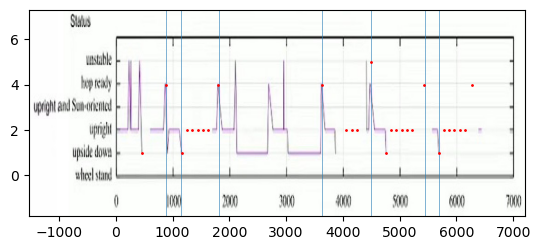

In [ ]:
%matplotlib inline
fig, ax = plt.subplots()
for h in hops_in_waveform:
    ax.axvline(time_to_ti(h), linewidth=0.4)
ax.imshow(bochum_plot, extent=(-1536, 7200, -1.8, 7.3), aspect=400)
ax.plot(times, plot_values, 'r.', markersize=2);

In [ ]:
rover_status = {
    0: "wheel stand",
    1: "upside down",
    2: "upright",
    3: "upright and Sun-orientied",
    4: "hop ready",
    5: "unstable",
}